# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
NDIM = 5 # number of parameters

# Simulator

Given parameters $a, b, c, d, e$ we write the simulator as a sum of functions of position and functions of random variables. The checker pattern is defined 

$$ a \cos(x + 2 b) \cos(y + 2 c). $$

Given $n \sim \mathcal{N}(-0.3, 1)$, the point source random variable is a function of $n$ such that

$$ d \, 10^{e n}. $$

With another noise random variable $noise \sim \mathcal{N}(0, 0.1)$, finally the image in full is

$$ 5 a \cos(x + 2 b) \cos(y + 2 c) + d \, 10^{e n} + noise .$$

In [3]:
# A toy model with a diffuse and point source component

def model(z, sigma = .1):
    x = np.linspace(-5, 5, 50, 50)
    X, Y = np.meshgrid(x,x)
    diff = np.cos(X+z[1]*2)*np.cos(Y+z[2]*2)*z[0]
    p = np.random.randn(*X.shape)*z[4]-0.3
    psc = 10**p*z[3]
    n = np.random.randn(*X.shape)*sigma
    out = (diff*5 + psc + n)
    return out

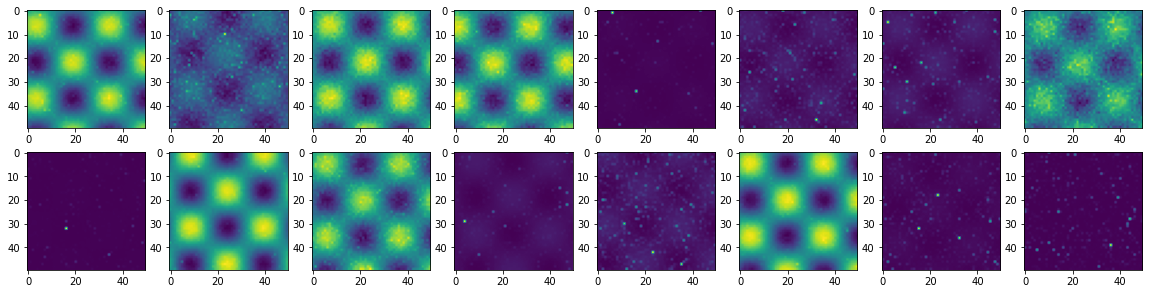

In [4]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 8, i+1)
    z0 = np.random.rand(5)
    x0 = model(z0)
    plt.imshow(x0)
    
z0 = np.ones(5)*0.5
x0 = model(z0)

In [5]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0a = torch.nn.Conv2d(1, 100, 1)
        self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv0a(x)
        x = torch.relu(x)
        x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [6]:
# Instantiate network

sw = swyft.SWYFT(x0, model, zdim = 5, device = DEVICE, max_epochs = 10, head = Head)
sw.run(nrounds = 2)

Number of output features: 160


100%|██████████| 47/47 [00:00<00:00, 262.74it/s]


Constrained posterior volume: 0.551795111111111


100%|██████████| 47/47 [00:00<00:00, 238.77it/s]


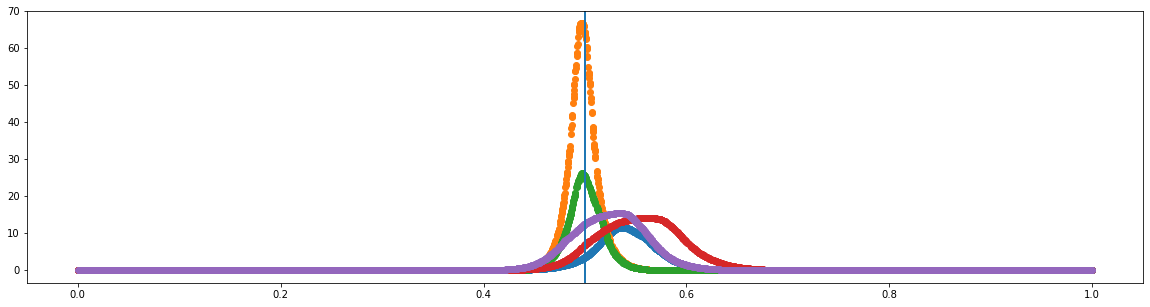

In [7]:
plt.figure(figsize=(20, 5))
for i in range(5):
    zgrid, lnLgrid = sw.posterior(i)
    plt.axvline(z0[i])
    plt.scatter(zgrid[:], np.exp(lnLgrid[:]))

In [8]:
sw.comb([[0, 1]])

Number of output features: 160


100%|██████████| 47/47 [00:00<00:00, 304.11it/s]


(0.0, 1.0)

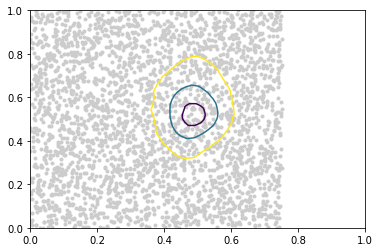

In [9]:
zgrid, lnLgrid = sw.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9])
plt.xlim([0, 1])
plt.ylim([0, 1])